In [22]:
import requests
import sqlite3
from time import sleep
from datetime import datetime, timedelta, date
from requests.exceptions import ConnectTimeout

# Configuración de la conexión a la base de datos SQLite
conn = sqlite3.connect('proyecto.db')
c = conn.cursor()

# Método para crear la tabla tokens en la base de datos
def create_tokens_table():
    c.execute('''CREATE TABLE IF NOT EXISTS tokens (
                    access_token TEXT,
                    refresh_token TEXT,
                    expiration_date TEXT
                )''')

# Verificar si la tabla tokens existe y crearla si no existe
create_tokens_table()

# Método para obtener el access_token y refresh_token de la base de datos
def get_tokens():
    c.execute("SELECT * FROM tokens")
    tokens = c.fetchone()
    if tokens is None:
        return None
    access_token, refresh_token, expiration_date = tokens
    expiration_date = datetime.strptime(expiration_date, '%Y-%m-%d %H:%M:%S')
    return access_token, refresh_token, expiration_date

# Método para guardar el access_token y refresh_token en la base de datos
def save_tokens(access_token, refresh_token, expiration_date):
    c.execute("DELETE FROM tokens")
    c.execute("INSERT INTO tokens VALUES (?, ?, ?)",
            (access_token, refresh_token, expiration_date))
    conn.commit()

# Método para obtener un nuevo access_token y refresh_token
def get_new_tokens(refresh_token):
    url = "https://api.mercadolibre.com/oauth/token"
    payload = {
        "grant_type": "refresh_token",
        "client_id": "5030313997317379",
        "client_secret": "zTJax3dLAiog35gQdaOVEhTSwxXxbTTY",
        "refresh_token": refresh_token
    }
    response = requests.post(url, data=payload)
    response.raise_for_status()
    data = response.json()
    access_token = data['access_token']
    refresh_token = data['refresh_token']
    expires_in = data['expires_in']
    expiration_date = datetime.now() + timedelta(seconds=expires_in)
    expiration_date_str = expiration_date.strftime('%Y-%m-%d %H:%M:%S')
    save_tokens(access_token, refresh_token, expiration_date_str)
    return access_token, refresh_token, expiration_date_str

# Método para hacer la petición con el access_token
def make_request(access_token, url):
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    data = response.json()
    return data

# Método para hacer una petición a la API
def do_request(url, params=None):
    tokens = get_tokens()
    if tokens is None or tokens[2] < datetime.now():
        refresh_token = tokens[1] if tokens is not None else input("Ingrese refresh_token: ")
        access_token, refresh_token, expiration_date = get_new_tokens(refresh_token)
    else:
        access_token, refresh_token, expiration_date = tokens
    
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    retries = 3  # Número máximo de reintentos
    retry_delay = 30  # Tiempo de espera en segundos antes de cada reintento
    
    for i in range(retries):
        try:
            response = requests.get(url, params=params, headers=headers, timeout=10)  # Establece un tiempo de espera de 10 segundos
            response.raise_for_status()
            data = response.json()
            return data
        except ConnectTimeout:
            print("Error de tiempo de espera de conexión. Se realizará un reintento después de 30 segundos...")
            sleep(retry_delay)
    
    print("Se ha excedido el número máximo de intentos de conexión. Se aborta la solicitud.")
    return None

# Método para obtener las visitas de cada producto
def get_product_visits(product_id):
    today = date.today()
    last_month = today - timedelta(days=30)
    
    endpoint = f"https://api.mercadolibre.com/visits/items"
    params = {
        "ids": product_id,
        "date_from": last_month.isoformat(),
        "date_to": today.isoformat()
    }

    # Aquí se utiliza la función do_request para realizar la solicitud con el access token
    response = do_request(endpoint, params=params)
    if response and isinstance(response, dict):
        product_visits = response.get(product_id)
        return product_visits
    
    return None



url = "https://api.mercadolibre.com/trends/MLC"

productos = {
    "tablets": "https://api.mercadolibre.com/sites/MLC/search?category=MLC82067",
    "notebooks": "https://api.mercadolibre.com/sites/MLC/search?category=MLC1652",
    "pcs": "https://api.mercadolibre.com/sites/MLC/search?category=MLC181025",
    "impresoras": "https://api.mercadolibre.com/sites/MLC/search?category=MLC1676"
}
# datos json
datos_json = do_request(productos["tablets"])['results']

In [2]:
datos_json

[{'id': 'MLC933990141',
  'title': 'Apple iPad (9ª Generación) 10.2  Wi-fi 64gb - Color Plata',
  'condition': 'new',
  'thumbnail_id': '907886-MLU69497668167_052023',
  'catalog_product_id': 'MLC18498454',
  'listing_type_id': 'gold_pro',
  'permalink': 'https://www.mercadolibre.cl/apple-ipad-9-generacion-102-wi-fi-64gb-color-plata/p/MLC18498454',
  'buying_mode': 'buy_it_now',
  'site_id': 'MLC',
  'category_id': 'MLC82067',
  'domain_id': 'MLC-TABLETS',
  'thumbnail': 'http://http2.mlstatic.com/D_907886-MLU69497668167_052023-I.jpg',
  'currency_id': 'CLP',
  'order_backend': 1,
  'price': 309990,
  'original_price': 372990,
  'sale_price': None,
  'sold_quantity': 500,
  'available_quantity': 500,
  'official_store_id': 1078,
  'official_store_name': 'Apple',
  'use_thumbnail_id': True,
  'accepts_mercadopago': True,
  'tags': ['extended_warranty_eligible',
   'good_quality_picture',
   'good_quality_thumbnail',
   'immediate_payment',
   'cart_eligible',
   'best_seller_candidate',

In [23]:
%%time

import pandas as pd
import json
from time import sleep

# Método para crear la tabla en la base de datos
def create_table(table_name):
    c.execute(f'''CREATE TABLE IF NOT EXISTS {table_name} (
                    id TEXT,
                    title TEXT,
                    condition TEXT,
                    price INTEGER,
                    permalink TEXT,
                    thumbnail TEXT,
                    sold_quantity INTEGER,
                    available_quantity INTEGER,
                    seller_id TEXT,
                    seller_nickname TEXT,
                    brand TEXT,
                    line TEXT,
                    model TEXT,
                    shipping INTEGER,
                    visits_last_month INTEGER,
                    date_retrieved TEXT
                )''')
    
# Método para insertar los datos en la tabla
def insert_data(table_name, data):
    columns = ', '.join(data[0].keys())
    placeholders = ', '.join([':' + key for key in data[0].keys()])
    query = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
    c.executemany(query, data)
    conn.commit()

# Método para obtener los datos de la tabla correspondientes a esta semana
def get_data(table_name):
    # Obtener la fecha de inicio y fin de la semana actual
    fecha_actual = datetime.now().date()
    fecha_inicio_semana = fecha_actual - timedelta(days=fecha_actual.weekday())
    fecha_fin_semana = fecha_inicio_semana + timedelta(days=6)

    # Convertir las fechas a strings
    fecha_inicio_semana_str = fecha_inicio_semana.strftime('%Y-%m-%d')
    fecha_fin_semana_str = fecha_fin_semana.strftime('%Y-%m-%d')

    # Consulta SQL para obtener los datos de la semana actual
    query = f"SELECT * FROM {table_name} WHERE date_retrieved BETWEEN ? AND ?"
    c.execute(query, (fecha_inicio_semana_str, fecha_fin_semana_str))

    # Obtener los nombres de las columnas
    column_names = [description[0] for description in c.description]

    # Obtener los datos de la consulta
    rows = c.fetchall()

    # Crear el DataFrame con los datos y los nombres de las columnas
    df = pd.DataFrame(rows, columns=column_names)

    return df

# Método para verificar si los datos de la API son más viejos a una semana
def check_data_age(table_name):
    c.execute(f"SELECT MAX(date_retrieved) FROM {table_name}")
    retrieved_date = c.fetchone()[0]
    if retrieved_date is None:
        return True
    else:
        retrieved_date = datetime.strptime(retrieved_date, '%Y-%m-%d %H:%M:%S')
        return datetime.now() - retrieved_date > timedelta(days=7)


# ...

def obtener_datos_por_pagina(total_resultados, url, table_name):
    resultados_por_pagina = 50
    paginas = total_resultados // resultados_por_pagina

    datos_filtrados_full = []

    for pagina in range(1, paginas + 1):
        parametros = {
            "offset": (pagina - 1) * resultados_por_pagina,
            "limit": resultados_por_pagina
        }
        respuesta = do_request(url, parametros)
        if "results" in respuesta and respuesta["results"]:
            datos_pagina = respuesta["results"]
        else:
            break

        for publicacion in datos_pagina:
            publicacion_filtrada = {
                "id": publicacion["id"],
                "title": publicacion["title"],
                "condition": publicacion["condition"],
                "price": publicacion["price"],
                "permalink": publicacion["permalink"],
                "thumbnail": publicacion["thumbnail"],
                "sold_quantity": publicacion["sold_quantity"],
                "available_quantity": publicacion["available_quantity"],
                "seller_id": publicacion["seller"]["id"],
                "seller_nickname": publicacion["seller"]["nickname"],
                "brand": None,
                "line": None,
                "model": None,
                "shipping": publicacion["shipping"]["free_shipping"],
                "visits_last_month": get_product_visits(publicacion["id"]),
                "date_retrieved": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }
            for atributo in publicacion["attributes"]:
                if atributo["id"] == "BRAND":
                    publicacion_filtrada["brand"] = atributo["value_name"]
                elif atributo["id"] == "LINE":
                    publicacion_filtrada["line"] = atributo["value_name"]
                elif atributo["id"] == "MODEL":
                    publicacion_filtrada["model"] = atributo["value_name"]

            datos_filtrados_full.append(publicacion_filtrada)

    # Inserta los datos en la tabla
    insert_data(table_name, datos_filtrados_full)

    dataframe = pd.DataFrame(datos_filtrados_full)

    return dataframe


total_resultados = 20000

# Ejecuta la función y obtiene los datos filtrados por página si es necesario
def obtener_data(producto):
    create_table(producto)
    if check_data_age(producto):
        df_product = obtener_datos_por_pagina(total_resultados, productos[producto], producto)
    else:
        # Obtiene los datos de la tabla
        df_product = get_data(producto)
    return df_product


# Llama a la función obtener_data con el producto "notebooks"
df_notebooks = obtener_data("notebooks")
df_tablets = obtener_data("tablets")
df_pcs = obtener_data("pcs")
df_impresoras = obtener_data("impresoras")

Error en la solicitud: 403 Client Error: Forbidden for url: https://api.mercadolibre.com/sites/MLC/search?category=MLC1676&offset=4000&limit=50
Se realizará un reintento después de 30 segundos...
Error en la solicitud: 403 Client Error: Forbidden for url: https://api.mercadolibre.com/sites/MLC/search?category=MLC1676&offset=4000&limit=50
Se realizará un reintento después de 30 segundos...
Error en la solicitud: 403 Client Error: Forbidden for url: https://api.mercadolibre.com/sites/MLC/search?category=MLC1676&offset=4000&limit=50
Se realizará un reintento después de 30 segundos...
Se ha excedido el número máximo de intentos de conexión. Se aborta la solicitud.
CPU times: total: 1min 3s
Wall time: 21min 36s


In [4]:
df_notebooks.head()

,id,title,condition,price,permalink,thumbnail,sold_quantity,available_quantity,seller_id,seller_nickname,brand,line,model,shipping,visits_last_month,date_retrieved
0,MLC1762141194,"Notebook Hp 14-dq0502la Negra 14 , Intel Celer...",new,199990,https://www.mercadolibre.cl/notebook-hp-14-dq0...,http://http2.mlstatic.com/D_903480-MLA70107832...,50,50,433323657,HP TIENDAOFICIAL,HP,Notebook,14-dq0502la,1,4743,2023-07-18 12:02:55
1,MLC1723800168,Notebook Hp Pavilion 14-dy0501la Plateada Natu...,new,399990,https://www.mercadolibre.cl/notebook-hp-pavili...,http://http2.mlstatic.com/D_796298-MLA48455331...,50,100,433323657,HP TIENDAOFICIAL,HP,Pavilion,14-dy0501la,1,4036,2023-07-18 12:02:55
2,MLC1591946838,"Notebook Hp 240 G9 Plateada 14 , Intel Celeron...",new,217000,https://www.mercadolibre.cl/notebook-hp-240-g9...,http://http2.mlstatic.com/D_809147-MLA52105513...,150,1,791863127,OPORTUTEK-CHILE,HP,None,240 G9,1,4247,2023-07-18 12:02:55
3,MLC979733842,"Macbook Air M1 2020 Gris Espacial 13.3 , Apple...",new,749990,https://www.mercadolibre.cl/macbook-air-m1-202...,http://http2.mlstatic.com/D_614885-MLA49588273...,500,100,550063615,MERCADOLIBRE ELECTRONICA_CL,Apple,MacBook Air,M1 2020,1,120145,2023-07-18 12:02:56
4,MLC1131351756,"Macbook Air M1 2020 Plata 13.3 , Apple M1 8gb...",new,749990,https://www.mercadolibre.cl/macbook-air-m1-202...,http://http2.mlstatic.com/D_927163-MLA48622311...,250,50,550063615,MERCADOLIBRE ELECTRONICA_CL,Apple,MacBook Air,M1 2020,1,33504,2023-07-18 12:02:56


In [5]:
df_notebooks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  3985 non-null   object
 1   title               3985 non-null   object
 2   condition           3985 non-null   object
 3   price               3985 non-null   int64 
 4   permalink           3985 non-null   object
 5   thumbnail           3985 non-null   object
 6   sold_quantity       3985 non-null   int64 
 7   available_quantity  3985 non-null   int64 
 8   seller_id           3985 non-null   object
 9   seller_nickname     3985 non-null   object
 10  brand               3983 non-null   object
 11  line                3361 non-null   object
 12  model               3893 non-null   object
 13  shipping            3985 non-null   int64 
 14  visits_last_month   3985 non-null   int64 
 15  date_retrieved      3985 non-null   object
dtypes: int64(5), object(11)


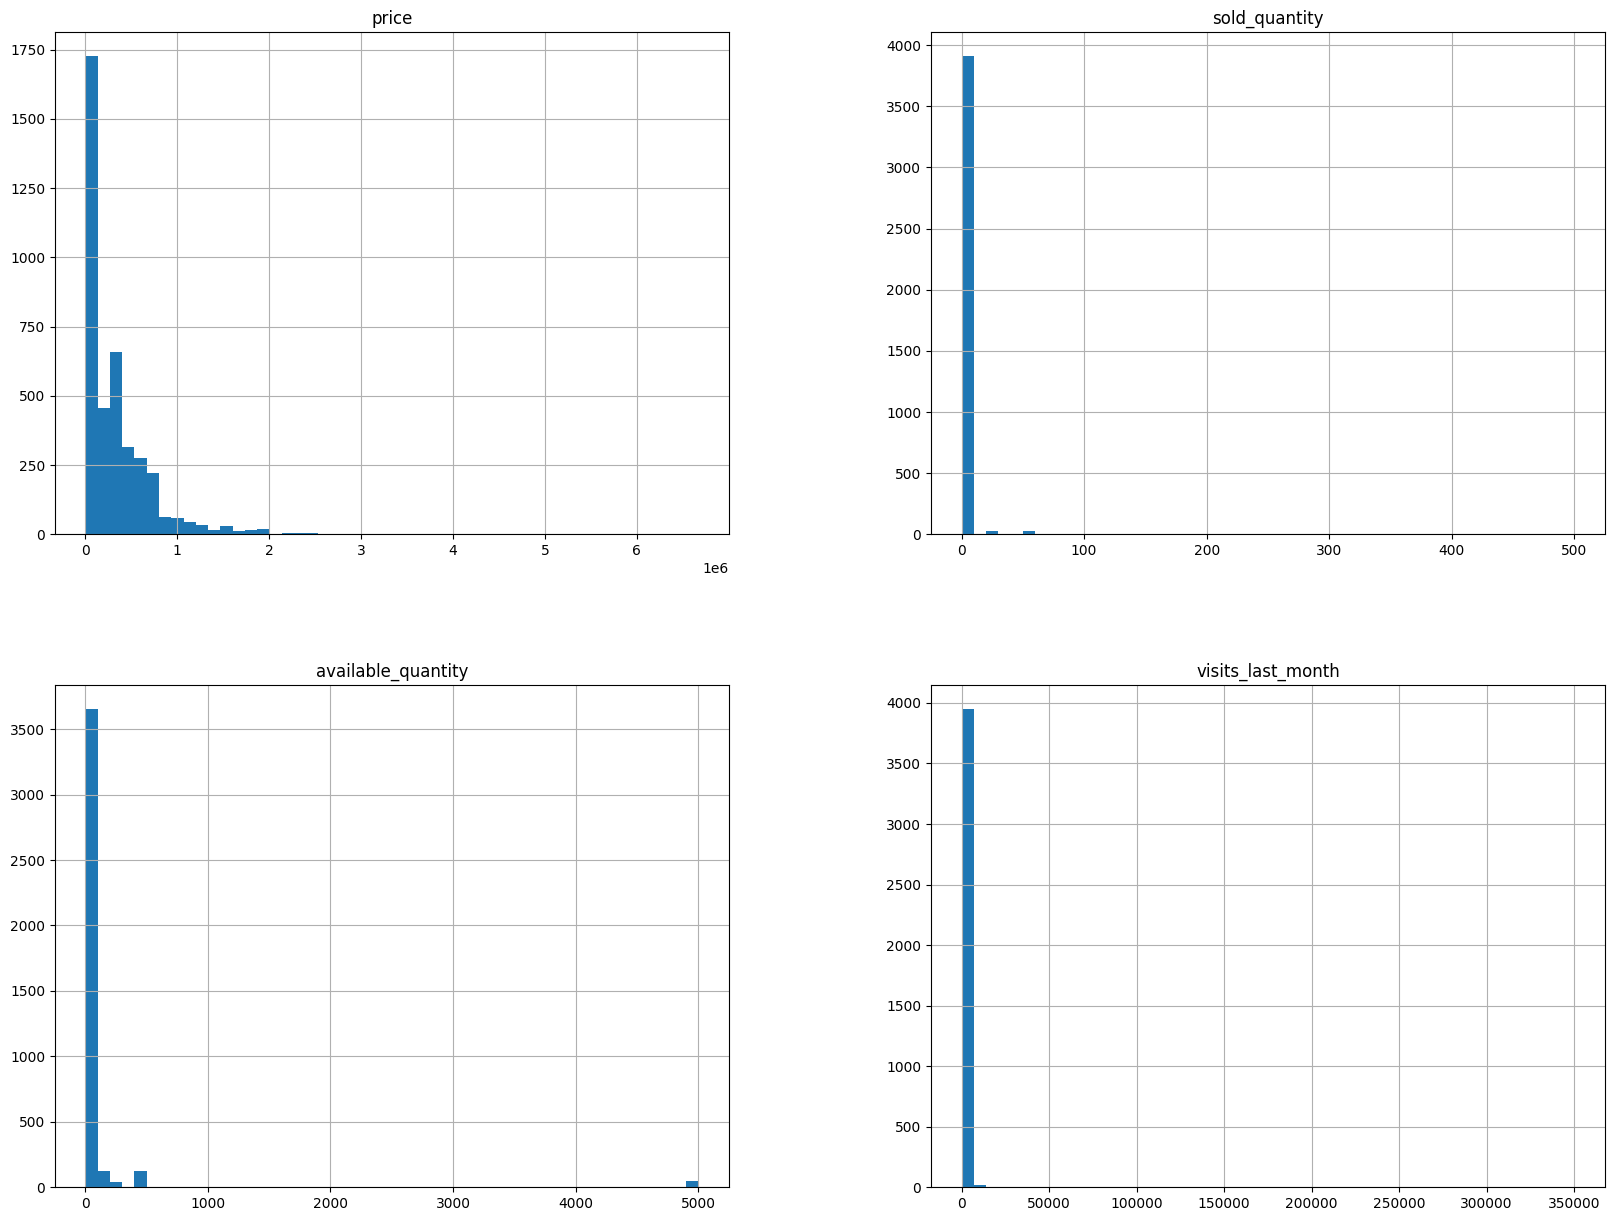

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
# Lista de columnas int64 a incluir en el histograma
columns = ['price', 'sold_quantity', 'available_quantity', 'visits_last_month']

# Generar histogramas para las columnas int64 seleccionadas
df_notebooks[columns].hist(bins=50, figsize=(20, 15))
plt.show()

In [7]:
a, _, _ = get_tokens()
a

'APP_USR-5030313997317379-071812-419229be5d31058f3e2d6c004599106b-675440595'

In [8]:
df_notebooks["sold_quantity"].value_counts()

sold_quantity
0      3051
1       395
5       172
2       155
3        97
4        39
25       32
50       26
100       5
150       4
500       4
250       3
200       2
Name: count, dtype: int64

In [9]:
print(date.today().isoformat())

2023-07-18


In [10]:
count_values = df_notebooks["visits_last_month"].value_counts().sort_index()
sorted_values = count_values.sort_index()
print(sorted_values)

visits_last_month
0         316
1          98
2          79
3          73
4          60
         ... 
57587       1
67104       1
73132       1
120145      1
350073      1
Name: count, Length: 945, dtype: int64


In [11]:
notebooks_int = df_notebooks.select_dtypes(include=['int64','float64'])
corr_matrix = notebooks_int.corr()
corr_matrix

,price,sold_quantity,available_quantity,shipping,visits_last_month
price,1.000000,0.046319,-0.092028,0.446213,0.049106
sold_quantity,0.046319,1.000000,-0.004737,0.062647,0.758555
available_quantity,-0.092028,-0.004737,1.000000,0.097393,-0.005174
shipping,0.446213,0.062647,0.097393,1.000000,0.040001
visits_last_month,0.049106,0.758555,-0.005174,0.040001,1.000000


In [12]:
corr_matrix["visits_last_month"].sort_values(ascending=False)

visits_last_month     1.000000
sold_quantity         0.758555
price                 0.049106
shipping              0.040001
available_quantity   -0.005174
Name: visits_last_month, dtype: float64

In [13]:
# Agrupar productos por catalog_product_id
grouped_products = df_notebooks.groupby('seller_nickname')
grouped_products.head()

,id,title,condition,price,permalink,thumbnail,sold_quantity,available_quantity,seller_id,seller_nickname,brand,line,model,shipping,visits_last_month,date_retrieved
0,MLC1762141194,"Notebook Hp 14-dq0502la Negra 14 , Intel Celer...",new,199990,https://www.mercadolibre.cl/notebook-hp-14-dq0...,http://http2.mlstatic.com/D_903480-MLA70107832...,50,50,433323657,HP TIENDAOFICIAL,HP,Notebook,14-dq0502la,1,4743,2023-07-18 12:02:55
1,MLC1723800168,Notebook Hp Pavilion 14-dy0501la Plateada Natu...,new,399990,https://www.mercadolibre.cl/notebook-hp-pavili...,http://http2.mlstatic.com/D_796298-MLA48455331...,50,100,433323657,HP TIENDAOFICIAL,HP,Pavilion,14-dy0501la,1,4036,2023-07-18 12:02:55
2,MLC1591946838,"Notebook Hp 240 G9 Plateada 14 , Intel Celeron...",new,217000,https://www.mercadolibre.cl/notebook-hp-240-g9...,http://http2.mlstatic.com/D_809147-MLA52105513...,150,1,791863127,OPORTUTEK-CHILE,HP,None,240 G9,1,4247,2023-07-18 12:02:55
3,MLC979733842,"Macbook Air M1 2020 Gris Espacial 13.3 , Apple...",new,749990,https://www.mercadolibre.cl/macbook-air-m1-202...,http://http2.mlstatic.com/D_614885-MLA49588273...,500,100,550063615,MERCADOLIBRE ELECTRONICA_CL,Apple,MacBook Air,M1 2020,1,120145,2023-07-18 12:02:56
4,MLC1131351756,"Macbook Air M1 2020 Plata 13.3 , Apple M1 8gb...",new,749990,https://www.mercadolibre.cl/macbook-air-m1-202...,http://http2.mlstatic.com/D_927163-MLA48622311...,250,50,550063615,MERCADOLIBRE ELECTRONICA_CL,Apple,MacBook Air,M1 2020,1,33504,2023-07-18 12:02:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3980,MLC1755890752,Gigabyte Aorus 5 Se4 I7 12700h Nvidia Rtx 3070...,new,1699990,https://articulo.mercadolibre.cl/MLC-175589075...,http://http2.mlstatic.com/D_602868-MLC70116865...,0,1,572203556,ALTONIVELSPA,Aorus,Aorus 5,se4,1,155,2023-07-18 12:22:50
3981,MLC1004341040,"Macbook Pro Mid 2012-2015 16gb De Ram, 500gb S...",used,470000,https://articulo.mercadolibre.cl/MLC-100434104...,http://http2.mlstatic.com/D_945776-MLC48791339...,1,1,87859372,CMR2812,Apple,MacBook Pro,A1278,0,365,2023-07-18 12:22:50
3982,MLC1093698218,Notebook Hp,used,130000,https://articulo.mercadolibre.cl/MLC-109369821...,http://http2.mlstatic.com/D_857941-MLC50487251...,0,1,55928413,SEBASTIANC.C,HP,Notebook,x,1,25,2023-07-18 12:22:51
3983,MLC1115396301,Laptor Acer A314-22,used,500000,https://articulo.mercadolibre.cl/MLC-111539630...,http://http2.mlstatic.com/D_870678-MLC52112445...,0,1,632471425,JOPE9396706,Acer,Aspire 3,A314-22,1,29,2023-07-18 12:22:51


In [14]:
#import openpyxl

#this = df_notebooks['producto_id'].value_counts().reset_index()
#merged_df = this.merge(df_notebooks[['producto_id', 'producto_nombre']], on='producto_id', how='left')
#merged_df = merged_df.drop_duplicates(subset=['producto_id']).reset_index()
#merged_df.to_excel('productos_a_comparar.xlsx', index=False)
#merged_df

KeyError: 'producto_id'

In [ ]:
vendedor = 'GIGABLACK'
resultado = df_notebooks[df_notebooks['seller_nickname'].str.contains(vendedor, case=False, regex=True)]
resultado.head()

In [ ]:
resultado.iloc[1,4]

In [ ]:
vendedor = 'GIGABLACK'
resultado = df_impresoras[df_impresoras['seller_nickname'].str.contains(vendedor, case=False, regex=True)]
resultado.head()

In [ ]:
resultado.iloc[0,4]

In [ ]:
resultado.iloc[0,1]

In [ ]:
resultado.iloc[1,1]

In [24]:
df_impresoras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  3996 non-null   object
 1   title               3996 non-null   object
 2   condition           3996 non-null   object
 3   price               3996 non-null   int64 
 4   permalink           3996 non-null   object
 5   thumbnail           3996 non-null   object
 6   sold_quantity       3996 non-null   int64 
 7   available_quantity  3996 non-null   int64 
 8   seller_id           3996 non-null   int64 
 9   seller_nickname     3996 non-null   object
 10  brand               3976 non-null   object
 11  line                818 non-null    object
 12  model               3970 non-null   object
 13  shipping            3996 non-null   bool  
 14  visits_last_month   3996 non-null   int64 
 15  date_retrieved      3996 non-null   object
dtypes: bool(1), int64(5), ob